# Imports
Import all the necessary libraries required for the project.

In [14]:
# **Imports**:
%pip install numpy pandas matplotlib seaborn scikit-learn
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
# Added import for Random Forest
from sklearn.ensemble import RandomForestClassifier


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Load Dataset
Load the dataset that will be used for training and testing the model.

In [10]:
# **Load Dataset**
# Load the dataset into a pandas DataFrame
dataset_pathCEAS_08 = '../sample_data/CEAS_08.csv'
dataset_pathNigerian_Fraud = '../sample_data/Nigerian_Fraud.csv'
dataset_pathSpamAssasin = '../sample_data/SpamAssasin.csv'


df1 = pd.read_csv(dataset_pathCEAS_08)
df2 = pd.read_csv(dataset_pathNigerian_Fraud)
df3 = pd.read_csv(dataset_pathSpamAssasin)
df = pd.concat([df1, df2, df3], ignore_index=True)

# Data Preprocessing
Perform data cleaning and preprocessing steps to prepare the data for modeling.

In [44]:
# **Data Preprocessing**
# Check for missing values
missing_values = df.isnull().sum()
df = df.dropna()
missing_values = df.isnull().sum()# Print
print(missing_values)
df.shape

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64


(45823, 7)

# Train Model

Accuracy: 0.9803600654664485
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8340
           1       0.99      0.97      0.98      9990

    accuracy                           0.98     18330
   macro avg       0.98      0.98      0.98     18330
weighted avg       0.98      0.98      0.98     18330



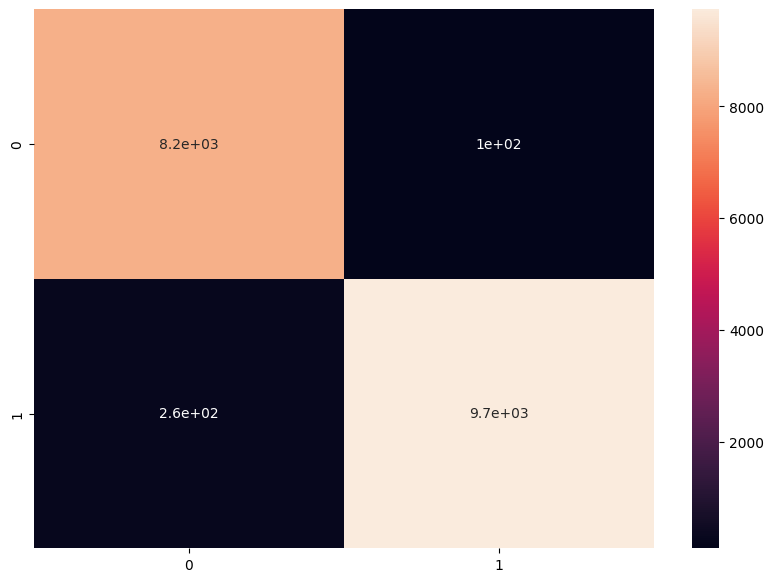

In [38]:
# Change input to include the full context: Subject and Body concatenated
X = "Subject: " + df["subject"] + ". Body: " + df["body"]
y = df['label']  # Use the 'label' column as the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Initialize and train a Random Forest model
model = RandomForestClassifier(random_state=1)
# Fit the model to the training data
model.fit(X_train_vec, y_train)
# y_pred is the predicted labels for the test set
y_pred = model.predict(X_test_vec)
# the accuracy score is the ratio of correctly predicted instances to the total instances
accuracy = accuracy_score(y_test, y_pred)
# Evaluate the model
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap with seaborn and matplotlib libraries
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.show()

# Save Model

In [39]:
# Save the model to disk
model_path = '../app/model/model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)
# Save the vectorizer to disk
vectorizer_path = '../app/model/vectorizer.pkl'
with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

# Fucntions 

In [42]:
# prompt: create fucntion to fecth the mdel test a body and return true or false
def predict_text(text, model, vectorizer):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])
    # Predict the label
    prediction = model.predict(text_vec)
    # Calculate the probability of each class 
    probabilities = model.predict_proba(text_vec)
    # Return True if predicted label is spam (assuming spam is labeled as 1), otherwise False
    is_spam = prediction[0] == 1
    return is_spam, probabilities

def get_suspect_words(text, model, vectorizer, top_n=5):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])

    # Get feature names (words) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get feature importances from the RandomForestClassifier
    feature_importances = model.feature_importances_

    # Get the nonzero feature indices in the transformed input
    word_indices = text_vec.nonzero()[1]

    # Get word importance scores
    word_importance = feature_importances[word_indices]

    # Pair words with their importance scores and sort them
    word_contributions = sorted(zip(feature_names[word_indices], word_importance), key=lambda x: abs(x[1]), reverse=True)

    # Return the top N suspect words
    return word_contributions[:top_n]
# Example usage: Predict using title and body in the format: {subject}. Body: {body}
subject = "Your Email Title"
body_text = "Your email content goes here"
sample_text = f"{subject}. Body: {body_text}"
is_spam, probabilities = predict_text(sample_text, model, vectorizer)
print("Is Spam:", is_spam)
print("Probabilities:", probabilities)
top_words = get_suspect_words(sample_text, model, vectorizer, top_n=5)
print("Top Suspect Words:", top_words)
# Example usage Subject: {subject}. Body: {body}” so that the model sees the full context. 
sample_text = "Hay send me your other email so I can forward it to you" 
is_spam, probabilities = predict_text(sample_text, model, vectorizer)
print("Is Spam:", is_spam)
print("Probabilities:", probabilities)
top_words = get_suspect_words(sample_text, model, vectorizer, top_n=5)
print("Top Suspect Words:", top_words)


Is Spam: True
Probabilities: [[0.1 0.9]]
Top Suspect Words: [('body', np.float64(0.014270801142479552)), ('your', np.float64(0.008129581711730342)), ('here', np.float64(0.0023959997095335615)), ('email', np.float64(0.0014440137505603852)), ('content', np.float64(0.00027307815891038713))]
Is Spam: True
Probabilities: [[0.39 0.61]]
Top Suspect Words: [('body', np.float64(0.014270801142479552)), ('your', np.float64(0.008129581711730342)), ('here', np.float64(0.0023959997095335615)), ('email', np.float64(0.0014440137505603852)), ('content', np.float64(0.00027307815891038713))]
Is Spam: True
Probabilities: [[0.39 0.61]]
Top Suspect Words: [('your', np.float64(0.008129581711730342)), ('it', np.float64(0.005794864694014112)), ('to', np.float64(0.0039149309564341815)), ('you', np.float64(0.003143251727919341)), ('so', np.float64(0.002337580936465149))]
Top Suspect Words: [('your', np.float64(0.008129581711730342)), ('it', np.float64(0.005794864694014112)), ('to', np.float64(0.00391493095643418

# Using Fucntion

In [43]:
subject = "Your Email Title"
test_body = "We detected that your password has been exposed in a data breach on another platform while doing a routine check for your security. You should reset your Duolingo password immediately, using a unique password not used elsewhere."
test_text = f"{subject}. Body: {test_body}"
is_spam, percentages = predict_text(test_text, model, vectorizer)
suspect_words = get_suspect_words(test_text, model, vectorizer)

if is_spam:
    print("The email is a phishing email. With a probability of", percentages[0][1].round(2)*100, "%")
else:
    print("The email is not a phishing email. With a probability of", percentages[0][0].round(2)*100, "%")

print("Top 5 suspect words:", suspect_words)

The email is a phishing email. With a probability of 60.0 %
Top 5 suspect words: [('body', np.float64(0.014270801142479552)), ('your', np.float64(0.008129581711730342)), ('on', np.float64(0.0073052762591488355)), ('not', np.float64(0.005954236271696054)), ('that', np.float64(0.004988542659160021))]


# Using Bert

In [25]:
# # Load Dataset
dataFrame = df
xData = dataFrame["body"]
yData = dataFrame["label"]  # 0: Not Phishing, 1: Phishing

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.2, random_state=42)


In [26]:
%pip install torch transformers

import torch
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\ruebe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from torch.utils.data import Dataset


In [28]:
# Tokenization using BERT
class EmailDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        return {key: val.squeeze(0) for key, val in encoding.items()}, torch.tensor(label)


In [29]:
# Tokenization using BERT
from torch.utils.data import DataLoader, Dataset


In [30]:
# Prepare Data Loaders
train_dataset = EmailDataset(X_train.tolist(), y_train.tolist())
test_dataset = EmailDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [31]:
from torch.optim import AdamW


In [32]:
# Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import get_scheduler


In [35]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)


In [36]:
num_epochs = 1  # Reduce the number of epochs to 1

for epoch in range(num_epochs):
    model.train()
    for batch, (inputs, labels) in enumerate(train_loader):
        if batch >= 5:  # Limit the number of batches to 5
            break
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6046138405799866
Epoch 1, Loss: 0.6046138405799866


In [37]:
# Evaluate Model (You can add accuracy, precision, recall, F1-score)
model.eval()
correct = 0
total = 0
batch_limit = 5  # Limit the number of batches to 5

for batch, (inputs, labels) in enumerate(test_loader):
    if batch >= batch_limit:
        break
    inputs = {key: val.to(device) for key, val in inputs.items()}
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=-1)
    correct += (predictions == labels).sum().item()
    total += labels.size(0)



print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9500
